# Tutorial 1: An RBC model

In this notebook we demonstrate the basic workflow of setting up and solving DSGE models in sequence space. All in the context of a simple RBC model.

For more examples and information on the SSJ toolkit, please visit our [GitHub page](https://github.com/shade-econ/sequence-jacobian).

1. Set up an RBC model
2. Steady state
3. Linearized impulse responses
4. Nonlinear perfect foresight responses

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1 Set up an RBC model


Let's consider a standard RBC model with the following equilibrium conditions

$$
\textbf{F}_t(\textbf{X}, Z) \equiv 
\begin{pmatrix}
C_t^{-\sigma} - \beta (1 + r_{t+1}) C_{t+1}^{-\sigma}
\\
w_t - \varphi L_t^{\nu} C_t^{\sigma}
\\
K_t - (1 - \delta) K_{t-1} - I_t
\\
r_t + \delta -\alpha Z_t \left(\frac{K_{t-1}}{L_t} \right)^{\alpha-1}
\\
w_t - (1-\alpha) Z_t \left(\frac{K_{t-1}}{L_t} \right)^{\alpha}
\\
Y_t - Z_t K_{t-1}^\alpha L_t^{1-\alpha}
\\
Y_t - C_t - I_t
\end{pmatrix}
= \begin{pmatrix} 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0\end{pmatrix},
\qquad t = 0, 1, \dots 
\tag{1}
$$
where $\textbf{X} = \{C, I, K, L, Y, r, w\}$ denotes the set of endogenous variables, and $Z$ is the only exogenous variable. As usual, labor market clearing is imposed implicitly and asset market clearing is omitted by Walras's law.

### 1.1 Directed Acyclic Graph (DAG) representation

The first step of solving the model is to come up with a Directed Acyclic Graph (DAG) representation for it and specify its blocks.

These blocks are collections of the model's equilibrium conditions, typically written in terms of the conceptual components of the model --- firm, household, market clearing conditions --- where each block takes a set of parameters and variables as inputs and produces another set as outputs. Formally, a block is a mapping between two sets of real sequences. 

<!-- Let $\mathbf{X} \equiv (x_t)_{t \in \mathbb{N}}$ denote a real sequence, and $\mathcal{I}$ and $\mathcal{O}$ denote the (finite) index sets of inputs and outputs. So, a block is a function $h: \{\mathbf{X}^i\}_{i \in \mathcal{I}} \to \{\mathbf{X}^o\}_{o \in \mathcal{O}}.$ -->

The DAG serves as the organizing framework for these blocks, which reduce the total set of variables and equations from those in the equilibrium conditions to the minimum number of target equations and associated unknown variables/parameters needed to represent the same system. The rest of the variables/equations in the system can then be written as explicit functions of these unknowns and collected into blocks.

#### The RBC DAG
The 7 equations of the RBC model can be organized as three blocks which form a DAG in two unknowns $U = \{K, L\}$ and two targets, the Euler equation and goods market clearing. We write the reduced system as
$$
\textbf{H}_t(\textbf{U}, Z) = 0
$$
Visual representation of DAGs is also very informative. We'll provide one for this model below.

#### Constructing a valid DAG
- Valid unknowns for a DAG are any variables/parameters that are inputs to a subset of the blocks but are not outputs.
- Valid targets are variables (or implicit equations) that are outputs of a subset of the blocks but not inputs.
- The only other requirement is that each unknown must map to at least one target and each target likewise must be mapped to by at minimum one unknown.

#### What makes a good DAG?

Most macro models admit many different DAG representations.
- a good DAG minimizes the number of unknowns
- a good DAG uses economically meaningful blocks that can easily be deployed in different models 

Coming up with a good DAG is an intuitive process that gets easier with practice. 

**Note**: a bad DAG still delivers the same answers as a good one, albeit somewhat slower and less elegantly.

### 1.2 Representing our RBC model

SSJ has several subclasses of the abstract **Block** class.
- `SimpleBlock` for explicit aggregate equilibrium conditions
- `SolvedBlock` for implicit aggregate equilibrium conditions
- `HetBlock` for collective actions of heterogeneous agents
- `CombinedBlock` for combination of multiple blocks

As we will see, blocks have a unified interface. By mixing these types blocks, we can represent most DSGE models. To represent our RBC model, we only need 3 simple blocks though.

In [2]:
from sequence_jacobian import simple, combine, create_model

@simple
def firm(K, L, Z, alpha, delta):
    r = alpha * Z * (K(-1) / L) ** (alpha-1) - delta
    w = (1 - alpha) * Z * (K(-1) / L) ** alpha
    Y = Z * K(-1) ** alpha * L ** (1 - alpha)
    return r, w, Y

@simple
def household(K, L, w, eis, frisch, vphi, delta):
    C = (w / vphi / L ** (1 / frisch)) ** eis
    I = K - (1 - delta) * K(-1)
    return C, I

@simple
def mkt_clearing(r, C, Y, I, K, L, w, eis, beta):
    goods_mkt = Y - C - I
    euler = C ** (-1 / eis) - beta * (1 + r(+1)) * C(+1) ** (-1 / eis)
    walras = C + K - (1 + r) * K(-1) - w * L
    return goods_mkt, euler, walras

- SimpleBlocks are initialized as regular Python functions, endowed with the decorator `@simple`. 
- Inside the function, we can refer to **leads/lags** of any inputs. The convention is as follows: 
   - `Y` refers to $Y_t$
   - `Y(-k)` refers to $Y_{t-k}$
   - `Y(k)` refers to $\mathbb{E}_t[Y_{t+k}]$
- We cannot ask for leads/lags of variables in the same SimpleBlock in which they were created. For example, we could not add the line `Y_lag = Y(-1)` to the firm block above. If we really wanted it, we could create a new SimpleBlock that takes `Y` as input and returns `Y_lag = Y(-1)`.
- Use SimpleBlocks only with **univariate** inputs and outputs. This is not a strict rule, but deviating from it imposes somewhat subtle restrictions on the model that we won't discuss here.   
- Of course, we have to import the constructor ``simple`` from the SSJ package before we can use it. For convenience, such commonly used functions can be imported from the top level `sequence_jacobian`, without having to remember their precise location.  

Recall that every block (including simple blocks) represents a function in sequence space.

In [3]:
print(firm)
print(f"Inputs: {firm.inputs}")
print(f"Outputs: {firm.outputs}")

<SimpleBlock 'firm'>
Inputs: ['K', 'L', 'Z', 'alpha', 'delta']
Outputs: ['r', 'w', 'Y']


Next, we combine the 3 simple blocks to get the RBC model. 

In [4]:
rbc = create_model([household, firm, mkt_clearing], name="RBC")

print(rbc)
print(f"Blocks: {rbc.blocks}")

<Model 'RBC'>
Blocks: [<SimpleBlock 'firm'>, <SimpleBlock 'household'>, <SimpleBlock 'mkt_clearing'>]


- The constructor `create_model` takes a list of blocks and (optionally) a name for the model.
- The order of blocks in the input list does not matter. When a `Model` is created, the constituent blocks are sorted in the correct order of evaluation based on their inputs and outputs. This is called a topological sort. The SSJ toolkit represents models just like we draw them, as a directed acyclic graph (DAG).
- We use the name `Model` for complete macro models such as `rbc`. A model is a special case of a `CombinedBlock` which can be any collection of blocks. The corresponding constructors---`create_model` for models, and `combine` for combined blocks---work identically.
- SSJ supports nesting combined blocks. For example, we could define a combined block that represents the private sector and combine that with market clearing to form the model.

In [5]:
from sequence_jacobian import combine

private = combine([firm, household], name='Private sector')
rbc2 = create_model([private, mkt_clearing], name='Nested RBC')

print(rbc2)
print(f"Blocks of RBC: {rbc2.blocks}")
print(f"Blocks of Private sector: {private.blocks}")

<Model 'Nested RBC'>
Blocks of RBC: [<CombinedBlock 'Private sector'>, <SimpleBlock 'mkt_clearing'>]
Blocks of Private sector: [<SimpleBlock 'firm'>, <SimpleBlock 'household'>]


### 1.3 Automated DAG visualization

We can visualize DAGs automatically using the `utilities/drawdag` module. The `drawdag` function takes a combined block (e.g. `rbc`), and the names of exogenous variables (`inputs`), unknowns, and targets.

This feature requires the [Graphviz](https://www.graphviz.org/) graph drawing software and the corresponding [Python package](https://pypi.org/project/graphviz/). Graphviz is not included in the Anaconda Python distribution, so you need to install it manually if you'd like to use it.

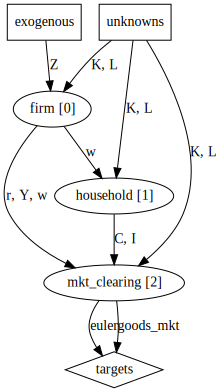

In [6]:
from sequence_jacobian import drawdag

unknowns = ['K', 'L']
targets = ['euler', 'goods_mkt']
inputs = ['Z']

drawdag(rbc, inputs, unknowns, targets)

With graphviz installed, the output of the cell above should look like this. 

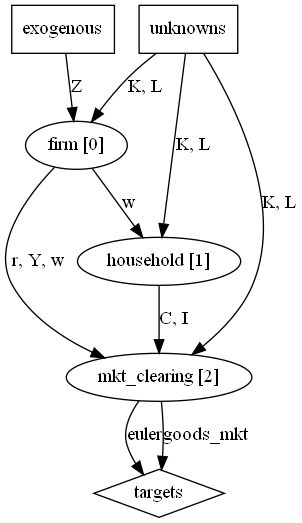

In [7]:
from IPython.display import Image

Image(filename='dag/RBC.png') 

**Note**: In the above DAG, we omit the various other variables/parameters that are pre-specified so the figure does not become too cluttered. However, one could visualize other variables such as the capital depreciation rate, $\delta = 0.025$ in our standard calibration, as being defined outside of the DAG --- they could be potential unknowns/inputs but in this configuration we simply fix their values.

## 2 Steady state

The next step of solving a model is to compute its steady state. SSJ provides functionality for computing a model's steady state from its DAG representation. This can be very convenient, but is optional. One can always compute the steady state manually.

**Note**: a more advanced usage of `steady_state` and `solve_steady_state` methods is covered in the one-asset HANK notebook.  

In [8]:
calibration = {"L": 1., "Z": 1., "r": 0.01, "eis": 1., "frisch": 1., "delta": 0.025, "alpha": 0.11}
unknowns_ss = {"vphi": 0.9, "beta": 0.99, "K": 2., "Z": 1.}
targets_ss = {"goods_mkt": 0., "r": 0.01, "euler": 0., "Y": 1.}

ss = rbc.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="hybr")

print(ss)

<SteadyStateDict: ['L', 'Z', 'r', 'eis', 'frisch', 'delta', 'alpha', 'vphi', 'beta', 'K', 'w', 'Y', 'C', 'I', 'goods_mkt', 'euler', 'walras']>


- `solve_steady_state` is a method that all Blocks have. It takes a calibration dict, unknowns to solve for (name and initial guess), and targets (name and value) that should be satisfied. 
- The `solver` keyword argument specifies which root-finding algorithm will be used to solve for the steady state. Any of the generic root-finding algorithms listed in `scipy.optimize` can be used.
- `solve_steady_state` returns a `SteadyStateDict` object, which is similar to Python dictionaries with some helpful extra functionality.
- To evaluate a block with constant inputs (without internal calibration), use the `steady_state` method, which takes only a calibration.

We can inspect the values contained in the returned `SteadyStateDict` object below to confirm that the targets are indeed satisfied. As an additional check we verify that Walras's law is satisfied by including the resource constraint as an additional variable in the DAG.

In [9]:
print(f"Euler equation: {ss['euler']}")
print(f"Goods market clearing: {ss['goods_mkt']}")
print(f"Walras law: {ss['walras']}")

Euler equation: 1.1102230246251565e-15
Goods market clearing: 2.220446049250313e-16
Walras law: -4.440892098500626e-16


## 3 Linearized solution

The linearized impulse responses of the model are fully characterized by the general equilibrium Jacobians $G = H_U^{-1}H_Z$ These matrices map *any* sequence of shocks into an impulse response, e.g. $dC = G^{C,Z} dZ.$ Once we have them, we're pretty much done!

We can get all of these in a single call to the `solve_jacobian` method of the `rbc` object. This function takes in the `SteadyStateDict` we obtained from calling `rbc.solve_steady_state`, the names of exogenous shocks, the names of unknown endogenous variables, the names of target equations, and the truncation horizon.

In [10]:
G = rbc.solve_jacobian(ss, unknowns, targets, inputs, T=300)

print(G)

<JacobianDict outputs=['K', 'L', 'C', 'I', 'r', 'w', 'Y', 'goods_mkt', 'euler', 'walras'], inputs=['Z']>


To see the $G$ matrices in action, let's construct two sequences of TFP shocks. First, a usual autoregressive shock that hits in period 0 (when the economy is assumed to be in steady state). Second, a news shock that, as agents learn in period 0, will hit TFP in period 10 and then decay at a constant rate. Note that such a news shock would be very costly to formulate recursively.

We store the two sequences as columns of a matrix $dZ.$ Let the shock on impact be 1% of steady state productivity, and the  quarterly autocorrelation be 0.8. 

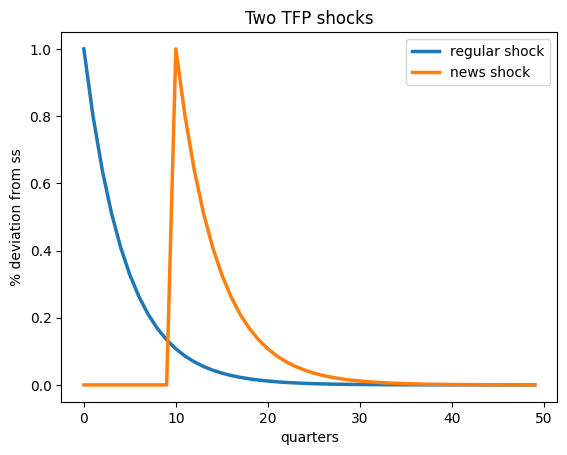

In [11]:
T, impact, rho, news = 300, 0.01, 0.8, 10
dZ = np.empty((T, 2))
dZ[:, 0] = impact * ss['Z'] * rho**np.arange(T)
dZ[:, 1] = np.concatenate((np.zeros(news), dZ[:-news, 0])) 

plt.plot(100*dZ[:50, 0]/ss['Z'], label='regular shock', linewidth=2.5)
plt.plot(100*dZ[:50, 1]/ss['Z'], label='news shock', linewidth=2.5)
plt.title(r'Two TFP shocks')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.legend()
plt.show()

Just apply the $G$ matrix to map these into impulses responses for, say, consumption. We multiply by 100 and divide by $C_{ss}$ just to get the answer in units of % deviations from steady state.

In [12]:
dC = 100 * G['C']['Z'] @ dZ / ss['C']

Now plot the result.

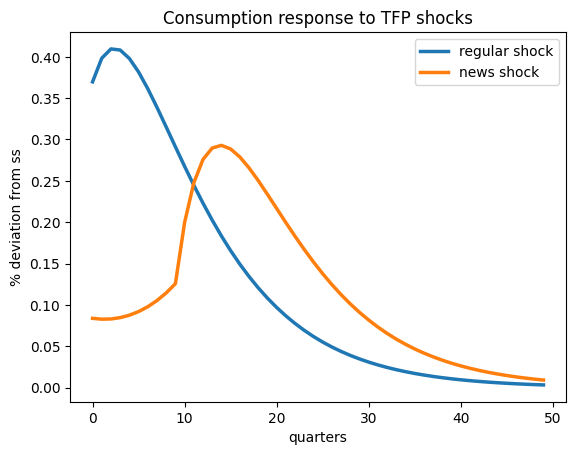

In [13]:
plt.plot(dC[:50, 0], label='regular shock', linewidth=2.5)
plt.plot(dC[:50, 1], label='news shock', linewidth=2.5)
plt.legend()
plt.title(r'Consumption response to TFP shocks')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.show()

For those of you familiar with Dynare, these impulse responses are identical to what you could obtain by running the perfect foresight solver `simul` with the `linear_approximation` option (which are, of course, also identical to those obtained by `stoch_simul(order=1)`).

Note that we can also perform the same calculation as the one above using the `solve_impulse_linear` method of the `rbc` object. This method is somewhat faster, because it only has to keep track of the responses to a specific shock (a vector) instead of the responses to all possible shocks (a matrix). 

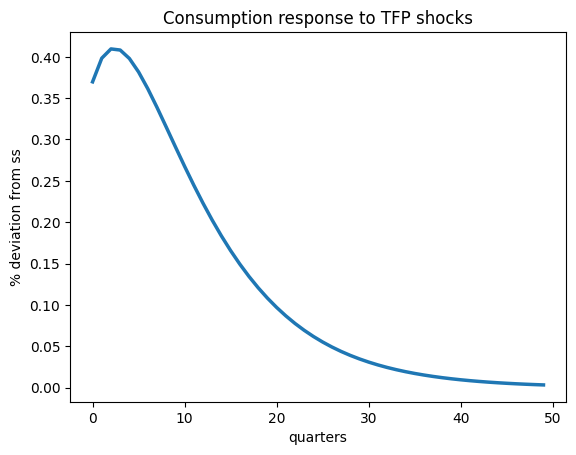

In [14]:
regular_Z_shock_path = {"Z": dZ[:, 0]}

td_lin = rbc.solve_impulse_linear(ss, unknowns, targets, regular_Z_shock_path)
td_lin_scaled = 100 * td_lin / ss  # scale all variables at once
dC_alt = td_lin_scaled['C']

plt.plot(dC_alt[:50], label='regular shock', linewidth=2.5)
plt.title(r'Consumption response to TFP shocks')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.show()

## 4 Nonlinear solution

To obtain nonlinear impulse responses that capture the different scale and sign effects of shocks, we use the `solve_impulse_nonlinear` method. Similarly to `solve_jacobian` above, it takes in the `SteadyStateDict` object, the names of unknown endogenous variables and the names of target equations.

However, the names of the exogenous variables would not be sufficient information, since we're calculating the nonlinear response to a specific shock path. Instead, `solve_impulse_nonlinear` requires the full *sequences* for any exogenous variables that are shocked.

So for the news shock above, we can just call: 

In [15]:
news_Z_shock_path = {"Z": dZ[:, 1]}
td_nonlin = rbc.solve_impulse_nonlinear(ss, unknowns, targets, news_Z_shock_path)

Solving RBC for ['K', 'L'] to hit ['euler', 'goods_mkt']
On iteration 0
   max error for euler is 1.04E-02
   max error for goods_mkt is 7.86E-04
On iteration 1
   max error for euler is 6.68E-05
   max error for goods_mkt is 6.75E-05
On iteration 2
   max error for euler is 3.85E-07
   max error for goods_mkt is 1.27E-07
On iteration 3
   max error for euler is 3.60E-09
   max error for goods_mkt is 1.47E-09


As we can see, the linearized solution is very accurate in this case.

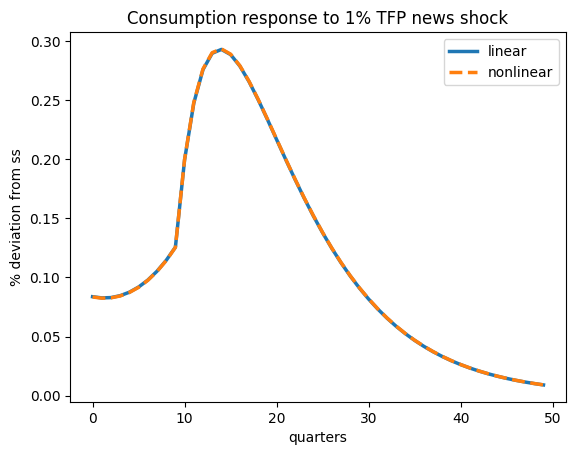

In [16]:
td_nonlin_scaled = 100 * td_nonlin / ss  # scale all variables at once
dC_nonlin = td_nonlin_scaled['C']

plt.plot(dC[:50, 1], label='linear', linewidth=2.5)
plt.plot(dC_nonlin[:50], label='nonlinear',  linestyle='--', linewidth=2.5)
plt.title(r'Consumption response to 1% TFP news shock')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.legend()
plt.show()

For those of you familiar with Dynare, these impulse responses are identical to what you could obtain by running the perfect foresight solver `simul`.